In [1]:
# import libraries
import numpy as np 
import pandas as pd  
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [20]:
# read data from csv file (columns TITLE and CATEGORY)

data = pd.read_csv('C:/Users/sumud/Documents/AI/attempt2/final/data-att5.csv', usecols=['Answer', 'Cat'])

In [21]:
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
# download stopwords
nltk.download('stopwords')

regexwhitespaces = re.compile('[/(){}\[\]\|@,;]')
regexsymbols = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))

def textcleanup(text):
    # remove html
    text = BeautifulSoup(text, "lxml").text  
    # convert to lower
    text = text.lower()  
    # remove whitespaces
    text = regexwhitespaces.sub(' ', text) 
    # remove symbols
    text = regexsymbols.sub('', text)
    # remove stopwords
    text = ' '.join(word for word in text.split() 
                    if word not in stopwords)
    return text
    
data['Answer'] = data['Answer'].apply(textcleanup)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# print the item count for each category
data.Cat.value_counts()

Loans              674
CreditCard         659
Info               655
Account            647
InternetBanking    642
Offers             632
Transfer           615
Branch             613
Balance            598
Fd                 572
Name: Cat, dtype: int64

In [25]:
# define the number of items per class - keep it a constant
items_per_cat = 500
# shuffle the data set
shufds = data.reindex(np.random.permutation(data.index))

# for each category, get items to match items_per_cat
CreditCard = shufds[shufds['Cat'] == 'CreditCard'][:items_per_cat]
Account = shufds[shufds['Cat'] == 'Account'][:items_per_cat]
Loans = shufds[shufds['Cat'] == 'Loans'][:items_per_cat]
Info = shufds[shufds['Cat'] == 'Info'][:items_per_cat]
Branch = shufds[shufds['Cat'] == 'Branch'][:items_per_cat]
Balance = shufds[shufds['Cat'] == 'Balance'][:items_per_cat]
InternetBanking = shufds[shufds['Cat'] == 'InternetBanking'][:items_per_cat]
Offers = shufds[shufds['Cat'] == 'Offers'][:items_per_cat]
Transfer = shufds[shufds['Cat'] == 'Transfer'][:items_per_cat]
Fd = shufds[shufds['Cat'] == 'Fd'][:items_per_cat]

# contacenate the list again
concated = pd.concat([CreditCard,Account,Loans,Info,Branch,Balance,InternetBanking,Offers,Transfer,Fd], ignore_index=True)
# shuffle
concated = concated.reindex(np.random.permutation(concated.index))
# create a column for LABEL (keep default to 0)
concated['LABEL'] = 0

In [26]:
# one hot encoding (assign an index to each label)
concated.loc[concated['Cat'] == 'CreditCard', 'LABEL'] = 0
concated.loc[concated['Cat'] == 'Account', 'LABEL'] = 1
concated.loc[concated['Cat'] == 'Loans', 'LABEL'] = 2
concated.loc[concated['Cat'] == 'Info', 'LABEL'] = 3
concated.loc[concated['Cat'] == 'Branch', 'LABEL'] = 4
concated.loc[concated['Cat'] == 'Balance', 'LABEL'] = 5
concated.loc[concated['Cat'] == 'InternetBanking', 'LABEL'] = 6
concated.loc[concated['Cat'] == 'Offers', 'LABEL'] = 7
concated.loc[concated['Cat'] == 'Transfer', 'LABEL'] = 8
concated.loc[concated['Cat'] == 'Fd', 'LABEL'] = 9
print(concated['LABEL'][:10])
# labels to categirical (10 classes)
labels = to_categorical(concated['LABEL'], num_classes=10)
print(labels[:10])

1181    2
4605    9
3271    6
121     0
108     0
609     1
1898    3
648     1
2239    4
4478    8
Name: LABEL, dtype: int64
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [28]:
concated.keys()

Index(['Answer', 'Cat', 'LABEL'], dtype='object')

In [29]:
concated['Cat'].values[0:10]

array(['Loans', 'Fd', 'InternetBanking', 'CreditCard', 'CreditCard',
       'Account', 'Info', 'Account', 'Branch', 'Transfer'], dtype=object)

In [31]:
# tokanize the dataset
# maximum number of words to consider is 10000
max_number_of_words = 50000
# maximum length of a single sentence is 130 words (remain will be trimmed)
max_len = 10
tokenizer = Tokenizer(num_words=max_number_of_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['Answer'].values)
sequences = tokenizer.texts_to_sequences(concated['Answer'].values)
word_index = tokenizer.word_index
print('Unique Tokens:', len(word_index))
# use pad sequnece to make all sentences same size
X = pad_sequences(sequences, maxlen=max_len)

Unique Tokens: 47040


In [32]:
# prepare train and test sets
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [36]:
# set number of epochs to 10
epochs = 10
# word embedding dimension
emb_dim = 128
# training batch size
batch_size = 32

labels[:2]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [34]:
# print the shapes of data sets
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

# create the model
model = Sequential()
# add word embedding layer
model.add(Embedding(max_number_of_words, emb_dim, input_length=X.shape[1]))
# add a dropout layer (70%)
model.add(SpatialDropout1D(0.7))
# add LSTM layer
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
# add a dence layer with 4 outputs and softmax activation
model.add(Dense(10, activation='softmax'))
# compile the model with categorical_crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# print the model summary
print(model.summary())

((3750, 10), (3750, 10), (1250, 10), (1250, 10))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 128)           6400000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 6,450,058
Trainable params: 6,450,058
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# train the model

history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 8s 3ms/step - loss: 2.2924 - acc: 0.1330 - val_loss: 2.2871 - val_acc: 0.1853
Epoch 2/10
3000/3000 [==============================] - 7s 2ms/step - loss: 2.2656 - acc: 0.1740 - val_loss: 2.2685 - val_acc: 0.2347
Epoch 3/10
3000/3000 [==============================] - 7s 2ms/step - loss: 2.2163 - acc: 0.2190 - val_loss: 2.2089 - val_acc: 0.2520
Epoch 4/10
3000/3000 [==============================] - 7s 2ms/step - loss: 2.1182 - acc: 0.2573 - val_loss: 2.0927 - val_acc: 0.2667
Epoch 5/10
3000/3000 [==============================] - 7s 2ms/step - loss: 2.0195 - acc: 0.2760 - val_loss: 2.0150 - val_acc: 0.3493
Epoch 6/10
3000/3000 [==============================] - 7s 2ms/step - loss: 1.9235 - acc: 0.3197 - val_loss: 1.9444 - val_acc: 0.3493
Epoch 7/10
3000/3000 [==============================] - 7s 2ms/step - loss: 1.7810 - acc: 0.3673 - val_loss: 1.8627 - val_acc: 0.3707
Epoch 8/10
3000

In [38]:
# evaluate the model
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1250/1250 [==============================] - 0s 176us/step
Test set
  Loss: 1.602
  Accuracy: 0.442


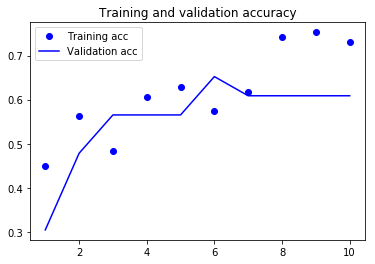

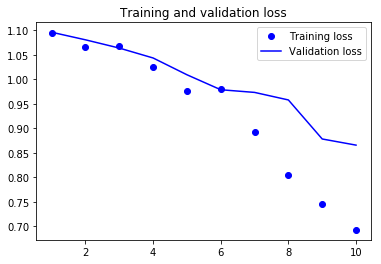

In [21]:
# generate the graph for training and validation accuracy, and training and validation loss
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
# try to predict a new text sentence
txt = ["how to get a credit card"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['Account', 'Transfer', 'CreditCard']
print(pred, labels[np.argmax(pred)])

[[0.79757947 0.09528358 0.10713701]] Account


In [24]:
# serialize model to JSON
model_json = model.to_json()
with open("C:/Users/sumud/Documents/AI/attempt2/final/model-4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/Users/sumud/Documents/AI/attempt2/final/model-4.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))